In [107]:
import os
import sys
import numpy as np
import pandas as pd
import os.path
from scipy import stats
import statsmodels

from statsmodels.stats.multitest import \
     multipletests as mult_test

data_path="/Users/abry4213/data/fMRI_classification/"

from core_classification_functions import *
current_path = os.getcwd()
from mixed_sigmoid_normalisation import MixedSigmoidScaler
data_path="/Users/abry4213/data/fMRI_classification/"

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [91]:
%%R
# Load tidyverse R package
suppressPackageStartupMessages({
    library(broom)
    library(cowplot)
    library(patchwork)
    library(see)
    library(tidyverse)
    theme_set(theme_cowplot())

    # Source my custom correctR code
    source("/Users/abry4213/github/correctR/R/repkfold_ttest.R")
})

In addition: Warning message:
package ‘broom’ was built under R version 4.3.3 


In [57]:
# Load metadata
UCLA_CNP_metadata = pd.read_feather(f"{data_path}/input_data/UCLA_CNP_sample_metadata_filtered.feather")
ABIDE_metadata = pd.read_feather(f"{data_path}/input_data/ABIDE_sample_metadata_filtered.feather").assign(Study = "ABIDE")
merged_metadata = pd.concat([UCLA_CNP_metadata, ABIDE_metadata])

pairwise_feature_info = pd.read_csv(f"{data_path}/feature_info/pairwise_feature_info.csv")

# Load SPI-wise balanced accuracy based on pairwise features
pairwise_balanced_accuracy_results_all_folds = pd.read_feather(f'{data_path}/classification_results/pairwise_balanced_accuracy_results_all_folds.feather')

if not os.path.isfile(f"{data_path}/time_series_features/ABIDE_pyspi14_mean_FC.feather"):
    # Load pyspi14 data for UCLA CNP and ABIDE
    UCLA_CNP_pyspi14 = pd.read_feather(f"{data_path}/time_series_features/UCLA_CNP_pyspi14_filtered.feather")
    ABIDE_pyspi14 = pd.read_feather(f"{data_path}/time_series_features/ABIDE_pyspi14_filtered.feather")

    # Take the mean value per SPI by Sample_ID
    UCLA_CNP_pyspi14_mean = UCLA_CNP_pyspi14.groupby(["Sample_ID", "SPI"])["value"].mean().reset_index()
    ABIDE_pyspi14_mean = ABIDE_pyspi14.groupby(["Sample_ID", "SPI"])["value"].mean().reset_index()

    # Save results to feather files
    UCLA_CNP_pyspi14_mean.to_feather(f"{data_path}/time_series_features/UCLA_CNP_pyspi14_mean_FC.feather")
    ABIDE_pyspi14_mean.to_feather(f"{data_path}/time_series_features/ABIDE_pyspi14_mean_FC.feather")
else:
    UCLA_CNP_pyspi14_mean = pd.read_feather(f"{data_path}/time_series_features/UCLA_CNP_pyspi14_mean_FC.feather")
    ABIDE_pyspi14_mean = pd.read_feather(f"{data_path}/time_series_features/ABIDE_pyspi14_mean_FC.feather")


# Concatenate pyspi14 data and merge with metadata
pyspi14_mean = pd.concat([UCLA_CNP_pyspi14_mean, ABIDE_pyspi14_mean])
pyspi14_mean = pyspi14_mean.merge(merged_metadata, on="Sample_ID")

/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "Site". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '
R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In min(d[d > tolerance]) :
R[write to console]: 
 
R[write to console]:  no non-missing arguments to min; returning Inf

R[write to console]: 2: 
R[write to console]: In stats::runif(length(x), -amount, amount) :
R[write to console]:  NAs produced

R[write to console]: 3: Removed 1343 rows containing missing values or values outside the scale range
(`geom_point()`). 



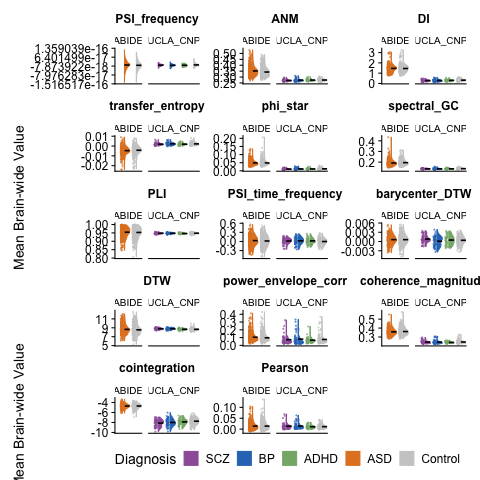

In [88]:
%%R -i pyspi14_mean,pairwise_feature_info

SPI_plot_list <- list()

for (i in 1:nrow(pairwise_feature_info)) {
    pyspi_name = pairwise_feature_info$pyspi_name[i]
    figure_name = pairwise_feature_info$Figure_name[i]

    SPI_plot <- pyspi14_mean %>% 
        filter(SPI==pyspi_name) %>% 
        mutate(Diagnosis = factor(Diagnosis, levels=c("SCZ", "BP", "ADHD", "ASD", "Control"))) %>%
        ggplot(data=., mapping=aes(x=Diagnosis, y=value, fill=Diagnosis, color=Diagnosis)) +
        geom_violinhalf(scale="width", position = position_nudge(x=0.2))  +
        stat_summary(color="black", fun="mean", geom="crossbar", width=0.45, linewidth=0.3, 
            show.legend=FALSE, position = position_nudge(x=0.41)) +
        geom_point(position = position_jitter(width = 0.1),
                    size = 1, alpha=0.7, stroke=0) +
        ggtitle(figure_name) +
        ylab("Mean Brain-wide Value") +
        facet_grid(.~Study, scales="free", space="free") +
        scale_fill_manual(values = c("SCZ" = "#9d60a8", 
                                    "BP" = "#2F77C0", 
                                    "ADHD" = "#84b278", 
                                    "ASD" = "#E28328",
                                    "Control" = "grey80"))  +
        scale_color_manual(values = c("SCZ" = "#9d60a8", 
                                    "BP" = "#2F77C0", 
                                    "ADHD" = "#84b278", 
                                    "ASD" = "#E28328",
                                    "Control" = "grey80")) +
        theme(legend.position = "bottom", 
            axis.text.x = element_blank(),
            axis.ticks.x = element_blank(),
            axis.title.x = element_blank(),
            strip.background = element_blank(), 
            strip.text = element_text(size=10),
            plot.title = element_text(hjust = 0.5, face="bold", size=12),
            panel.spacing.y = unit(-0.5, "lines"))

    SPI_plot_list[[i]] <- SPI_plot
}

wrap_plots(SPI_plot_list, ncol=3) +
  plot_layout(axis_titles = "collect", guides = "collect") & 
  theme(legend.position = 'bottom')

# ggsave("../../plots/pairwise_results/Mean_FC_values_by_SPI.svg", width=10, height=10, units="in", dpi=300)

In [93]:
%%R -i pyspi14_mean,pairwise_feature_info -o all_wilcox_results

# Compile a study lookup table
study_group_df <- data.frame(Study = c(rep("UCLA_CNP", 3), "ABIDE"),
                              Disorder = c("SCZ", "BP", "ADHD", "ASD"))

disorder_wilcox_test_results_list <- list()

for (i in 1:nrow(study_group_df)) {
    disorder <- study_group_df$Disorder[i]
    study <- study_group_df$Study[i]

    # Fit Wilcox rank-sum test
    disorder_wilcox_test_results <- pyspi14_mean %>% 
        filter(Diagnosis %in% c("Control", disorder)) %>%
        nest(data = -SPI) %>%
        mutate(
            fit = map(data, ~ wilcox.test(value ~ Diagnosis, data=.x)),
            tidied = map(fit, tidy)
        ) %>%
        unnest(tidied) %>% 
        dplyr::select(-data, -fit) %>%
        mutate(Study = study, Disorder = disorder)

    # Append results
    disorder_wilcox_test_results_list[[disorder]] <- disorder_wilcox_test_results
}

all_wilcox_results <- do.call(plyr::rbind.fill, disorder_wilcox_test_results_list)

/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "Site". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


In [97]:
pyspi14_mean.head()

,Sample_ID,SPI,value,index,Diagnosis,Age,Sex,Study,Site
0,sub-10159,anm,0.273333,0,Control,30.0,F,UCLA_CNP,NaN
1,sub-10159,bary_dtw_mean,0.001326,0,Control,30.0,F,UCLA_CNP,NaN
2,sub-10159,cohmag_multitaper_mean_fs-1_fmin-0_fmax-0-5,0.232388,0,Control,30.0,F,UCLA_CNP,NaN
3,sub-10159,coint_aeg_tstat_trend-ct_autolag-aic_maxlag-10,-7.469548,0,Control,30.0,F,UCLA_CNP,NaN
4,sub-10159,cov_EmpiricalCovariance,0.004516,0,Control,30.0,F,UCLA_CNP,NaN


In [108]:
study_group_df = pd.DataFrame({'Study': ["UCLA_CNP", "UCLA_CNP", "UCLA_CNP", "ABIDE"],
                                'Disorder': ["SCZ", "BP", "ADHD", "ASD"]})

# Iterate over each study and disorder, perform Wilcox rank-sum test for each SPI
disorder_wilcox_test_results_list = list()

for i in range(study_group_df.shape[0]):
    disorder = study_group_df.loc[i, "Disorder"]
    study = study_group_df.loc[i, "Study"]

    # Fit Wilcox rank-sum test
    for SPI in pyspi14_mean["SPI"].unique():
        control_values = pyspi14_mean.query("Diagnosis == 'Control' & SPI == @SPI & Study == @study")["value"]
        disorder_values = pyspi14_mean.query("Diagnosis == @disorder & SPI == @SPI & Study == @study")["value"]
        statistic, p_value = stats.ranksums(control_values, disorder_values)
        disorder_wilcox_test_results = pd.DataFrame({"SPI": [SPI],
                                                      "statistic": [statistic],
                                                      "p.value": [p_value],
                                                      "Study": [study],
                                                      "Disorder": [disorder]})
        disorder_wilcox_test_results_list.append(disorder_wilcox_test_results)

all_wilcox_results = pd.concat(disorder_wilcox_test_results_list)

# Group by disorder and apply Benjamini-Hochberg correction
all_wilcox_results["p.value"] = all_wilcox_results["p.value"].astype(float)
all_wilcox_results["p.value_corrected"] = all_wilcox_results.groupby("Disorder")["p.value"].transform(lambda x: mult_test(x, method="fdr_bh")[1])


## Fit a linear SVM trained just on the global mean

In [49]:
def classify_based_on_global_mean_FC(dataset_ID, disorder, data_path, pyspi14_mean, metadata, pipe, num_folds, num_repeats, CV_splitter, num_null_iters, num_jobs, Analysis_Type, grouping_var, classifier_type, scorers, scoring_names):
    main_output_file_base = f"{dataset_ID}_{disorder}_pyspi14_all_SPI_mean_{classifier_type}_{num_repeats}_repeats_{num_folds}_folds_CV"
    if not os.path.isfile(f"{data_path}/classification_results/balanced_accuracy/{dataset_ID}_{disorder}/{main_output_file_base}.feather"):
        # Define main output data file for this feature
        IDs_to_keep = metadata.query("Diagnosis in [@disorder, 'Control']")["Sample_ID"].tolist()
        disorder_pyspi14_data = pyspi14_mean.query("Sample_ID in @IDs_to_keep")

        all_SPI_res_list = []

        # Iterate over each SPI in pyspi14_mean
        for this_SPI in disorder_pyspi14_data.SPI.unique().tolist():

            # Filter data for this SPI
            this_SPI_data = disorder_pyspi14_data.query("SPI == @this_SPI")

            # Pivot from long to wide
            SPI_data_only = this_SPI_data['value'].values.reshape(-1, 1)

            # Extract sample ID and diagnosis
            class_labels = np.array([int(i==disorder) for i in this_SPI_data["Diagnosis"].tolist()])
            sample_IDs = np.array(this_SPI_data["Sample_ID"].tolist())

            # Run classification
            main_classification_res, _, _ = run_k_fold_classifier_for_feature(feature_data = SPI_data_only, 
                                                                                            pipe = pipe,
                                                                                            CV_splitter = CV_splitter,
                                                                                            class_labels=class_labels,
                                                                                            sample_IDs = sample_IDs,
                                                                                            scorers=scorers,
                                                                                            scoring_names=scoring_names,
                                                                                            num_null_iters=num_null_iters,
                                                                                            num_folds = num_folds,
                                                                                            num_repeats = num_repeats,
                                                                                            num_jobs = num_jobs)
            
            # Add 1 to Fold and Repeat
            main_classification_res["Fold"] = main_classification_res["Fold"] + 1
            main_classification_res["Repeat"] = main_classification_res["Repeat"] + 1
            
            # Assign key details to dataframes
            main_classification_res["Disorder"] = disorder
            main_classification_res["Study"] = dataset_ID
            main_classification_res["Analysis_Type"] = Analysis_Type
            main_classification_res["group_var"] = this_SPI
            main_classification_res["Classifier_Type"] = classifier_type

            # Append to list
            all_SPI_res_list.append(main_classification_res)

        # Concatenate results 
        all_SPI_res = pd.concat(all_SPI_res_list).reset_index()

        # Save results
        all_SPI_res.to_feather(f"{data_path}/classification_results/balanced_accuracy/{dataset_ID}_{disorder}/{main_output_file_base}.feather")
        

In [50]:
# Define classification parameters
model = svm.SVC(kernel="linear", C=1, class_weight="balanced")
pipe = Pipeline([('scaler', MixedSigmoidScaler(unit_variance=True)),
            ('model', model)])
num_folds=10
num_repeats=10
num_null_iters=0
num_jobs=1

# Analysis parameters
Analysis_Type="pyspi14_SPI"
grouping_var="covariance"
classifier_type="Linear_SVM_sklearn"

# Define scorers
scorers = [make_scorer(balanced_accuracy_score)]
scoring_names = ["Balanced_Accuracy"]

# Define RepeatedStratifiedKFold splitter
RepeatedStratifiedKFold_splitter = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=num_repeats, random_state=127)

# UCLA CNP classification
for disorder in ['SCZ', 'BP', 'ADHD']:
    dataset_ID = "UCLA_CNP"
    classify_based_on_global_mean_FC(dataset_ID, disorder, data_path, pyspi14_mean, UCLA_CNP_metadata, pipe, num_folds, num_repeats, RepeatedStratifiedKFold_splitter, num_null_iters, num_jobs, Analysis_Type, grouping_var, classifier_type, scorers, scoring_names)

# ABIDE classification
for disorder in ['ASD']:
    dataset_ID = "ABIDE"
    classify_based_on_global_mean_FC(dataset_ID, disorder, data_path, pyspi14_mean, ABIDE_metadata, pipe, num_folds, num_repeats, RepeatedStratifiedKFold_splitter, num_null_iters, num_jobs, Analysis_Type, grouping_var, classifier_type, scorers, scoring_names)

# Merge the SPI mean value results
if not os.path.exists(f"{data_path}/classification_results/pairwise_SPI_mean_values_balanced_accuracy_results_all_folds.feather"):
    SPI_mean_results_list = []
    for disorder in ['SCZ', 'BP', 'ADHD']:
        dataset_ID = "UCLA_CNP"
        SPI_mean_results = pd.read_feather(f"{data_path}/classification_results/balanced_accuracy/{dataset_ID}_{disorder}/{dataset_ID}_{disorder}_pyspi14_all_SPI_mean_{classifier_type}_{num_repeats}_repeats_{num_folds}_folds_CV.feather")
        SPI_mean_results_list.append(SPI_mean_results)
    for disorder in ['ASD']:
        dataset_ID = "ABIDE"
        SPI_mean_results = pd.read_feather(f"{data_path}/classification_results/balanced_accuracy/{dataset_ID}_{disorder}/{dataset_ID}_{disorder}_pyspi14_all_SPI_mean_{classifier_type}_{num_repeats}_repeats_{num_folds}_folds_CV.feather")
        SPI_mean_results_list.append(SPI_mean_results)

    # Concatenate results
    all_SPI_mean_results = pd.concat(SPI_mean_results_list, ignore_index=True)
    # Save to a feather file
    all_SPI_mean_results.to_feather(f"{data_path}/classification_results/pairwise_SPI_mean_values_balanced_accuracy_results_all_folds.feather")
else:
    all_SPI_mean_results = pd.read_feather(f"{data_path}/classification_results/pairwise_SPI_mean_values_balanced_accuracy_results_all_folds.feather")

In [51]:
all_SPI_mean_results.head()

,index,Balanced_Accuracy,Fold,Repeat,Disorder,Study,Analysis_Type,group_var,Classifier_Type
0,0,0.425000,1,1,SCZ,UCLA_CNP,pyspi14_SPI,anm,Linear_SVM_sklearn
1,1,0.775000,2,1,SCZ,UCLA_CNP,pyspi14_SPI,anm,Linear_SVM_sklearn
2,2,0.608333,3,1,SCZ,UCLA_CNP,pyspi14_SPI,anm,Linear_SVM_sklearn
3,3,0.466667,4,1,SCZ,UCLA_CNP,pyspi14_SPI,anm,Linear_SVM_sklearn
4,4,0.500000,5,1,SCZ,UCLA_CNP,pyspi14_SPI,anm,Linear_SVM_sklearn


In [83]:
pairwise_balacc_to_compare = pairwise_balanced_accuracy_results_all_folds.rename(columns={"group_var": "pyspi_name"}).assign(Analysis_Type = "full")
all_SPI_mean_results_to_compare = all_SPI_mean_results.rename(columns={"group_var": "pyspi_name"}).assign(Analysis_Type = "mean")


In [84]:
%%R -i all_SPI_mean_results_to_compare,pairwise_feature_info,pairwise_balacc_to_compare

all_SPI_mean_results_to_compare %>%
    plyr::rbind.fill(., pairwise_balacc_to_compare) %>%
    left_join(., pairwise_feature_info) %>%
    # filter(Figure_name=="Pearson") %>%
    mutate(Disorder = factor(Disorder, levels = c("SCZ", "BP", "ADHD", "ASD"))) %>%
    ggplot(data=., mapping=aes(x=Analysis_Type, y=Balanced_Accuracy*100, fill=Figure_name)) +
    geom_hline(yintercept=50, linetype="dashed", color="black") +
    geom_violinhalf(scale="width", position = position_nudge(x=0.2))  +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.45, linewidth=0.2, 
        show.legend=FALSE, position = position_nudge(x=0.41)) +
    geom_point(aes(color = Figure_name), position = position_jitter(width = 0.1),
               size = 1, alpha=0.5, stroke=0) +
    facet_grid(Disorder~Figure_name, scales="free", switch="y") +
    xlab("Statistic for Pairwise Interactions (SPI)") +
    ylab("Balanced Accuracy by Fold (%)") +
    theme(legend.position="none", 
          strip.placement = "outside",
          strip.background = element_blank(),
          strip.text = element_text(face="bold", angle=0)) 

# ggsave("../../plots/pairwise_results/Pairwise_Mean_FC_classification.svg", width=15, height=7, units="in", dpi=300)

Joining with `by = join_by(pyspi_name)`


In [87]:
%%R -i all_SPI_mean_results_to_compare,pairwise_balacc_to_compare,merged_metadata,pairwise_feature_info -o corrected_SPI_T_res

# Compile a study lookup table
study_group_df <- data.frame(Study = c(rep("UCLA_CNP", 3), "ABIDE"),
                              Disorder = c("SCZ", "BP", "ADHD", "ASD"))

run_correctR_group <- function(disorder, study, metadata, results_df) {
  # Find number of subjects for the specified comparison group
  num_subjects <- metadata %>%
    filter(Study == study, 
           Diagnosis %in% c("Control", disorder)) %>%
    distinct(Sample_ID) %>%
    nrow()
  
  # Compute the training and test fold sizes for 10-fold CV
  training_size <- ceiling(0.9*num_subjects)
  test_size <- floor(0.1*num_subjects)
  
  # Prep the resulting balanced accuracies with vs without univariate data
  data_for_correctR <- results_df %>%
    filter(Study == study, 
           Disorder == disorder) %>%
    dplyr::rename("model" = "Analysis_Type",
                  "k" = "Fold",
                  "r" = "Repeat",
                  "values" = "Balanced_Accuracy") %>%
    dplyr::select(model, pyspi_name, k, r, values) %>%
    dplyr::mutate(r = r + 1) %>%
    group_by(pyspi_name) %>%
    group_split()
  
  tryCatch({
    res <- data_for_correctR %>%
      purrr::map_df(~ as.data.frame(repkfold_ttest(data = .x %>% dplyr::select(-pyspi_name), 
                                                   n1 = training_size,
                                                   n2 = test_size,
                                                   k = 10,
                                                   r = 10, 
                                                   tailed = "two")) %>%
                      mutate(pyspi_name = unique(.x$pyspi_name))) %>%
      ungroup() %>%
      mutate(p_value_corr_BenjaminiHochberg = p.adjust(p.value, method="BH"),
             Disorder = disorder)
    
    return(res)}, 
    error = function(e) {
      print("error for disorder")
      print(disorder)
      print(e)
      return(data.frame(statistic = numeric(),
                        p.value = numeric(),
                        p_value_corr_BenjaminiHochberg = numeric(),
                        Disorder = character(), 
                        pyspi_name = character()))
    }
  )
}

results_df = plyr::rbind.fill(all_SPI_mean_results_to_compare, pairwise_balacc_to_compare)

corrected_SPI_T_res <- 1:nrow(study_group_df) %>%
  purrr::map_df(~ run_correctR_group(disorder = study_group_df$Disorder[.x],
                                     study = study_group_df$Study[.x],
                                     metadata = merged_metadata,
                                     results_df = results_df)) %>%
  left_join(., pairwise_feature_info)

/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '
/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "Site". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


Joining with `by = join_by(pyspi_name)`
